In [2]:
import yfinance as yf
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import shutil

In [3]:
TICKER = "NVDA"
historic_price = yf.download(TICKER)
prices = historic_price['Adj Close']

[*********************100%%**********************]  1 of 1 completed


In [4]:
MAX_HOLDING = 100

Simple moving average function for feature extraction. Takes in the length of the moving average

In [5]:
def get_sma(prices, MA):
    sma = []
    for pos1 in range(0, len(prices) - MA):
        sum = 0
        for change in range(MA, 0, -1):
            sum += prices.iloc[pos1 + change]
        sma.append(sum / MA)
    return sma

Standard deviation function for feature extraction. Takes in how long back to look to determine the standard deviation of a given price

In [88]:
def get_sd(prices, time):
    sd = []
    for pos1 in range(0, len(prices) - time):
        sum = 0
        for change in range(time, 0, -1):
            sum += prices.iloc[pos1 + change]
        mean = sum / time
        summa = 0
        for change in range(time, 0, -1):
            summa += (prices.iloc[pos1 + change] - mean) ** 2
        sd.append(math.sqrt(summa / time))
    return sd

Visit https://www.desmos.com/calculator/saxa0jcqds to see how time affects price with each function

In [89]:
time_effect1 = lambda L, x: 1-(x/L)
time_effect2 = lambda L, x: L/(x+L)
time_effect3 = lambda L, x: (-1/(L**2))(x**2)+1
time_effect3 = lambda L, x: -1/((x-L)**2)

Two different ways to normalize the answer data. Use normalize_forward if the stock has increased for most of its history and use normalize_average if the stock has been relatively stagnant

In [90]:
def normalize_forward(old_answer):
    answer = old_answer.copy()
    dp_factors = [answer[0]]
    for pos in range(1, len(answer)):
        dp_factors.append(max(abs(answer[pos]), abs(dp_factors[-1])))
        answer[pos] /= dp_factors[pos]
    answer[0] = 1
    return answer

def normalize_average(old_answer):
    answer = old_answer.copy()
    window = [abs(x) for x in answer[:int(MAX_HOLDING/2)]]
    max_answer = max(window)
    dp_max = [max_answer] * int(MAX_HOLDING/2)
    for pos in range(int(MAX_HOLDING/2), MAX_HOLDING):
        window.append(abs(answer[pos]))
        max_answer = max(max_answer, abs(answer[pos]))
        dp_max.append(abs(max_answer))
    for pos in range(MAX_HOLDING, len(answer)):
        if max_answer == window[0]:
            max_answer = max(window[1:])
        max_answer = max(max_answer, abs(answer[pos]))
        window.pop(0)
        window.append(abs(answer[pos]))
        dp_max.append(abs(max_answer))
    print(len(answer), len(dp_max))
    for pos in range(len(answer)):
        answer[pos] /= dp_max[pos]
    return answer

Calculates the mapping

In [91]:
answer = []
for pos1 in range(len(prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (prices.iloc[pos1 + pos2] - prices.iloc[pos1]) * time_effect1(MAX_HOLDING, pos2)
    answer.append(ans)
print(len(prices), len(answer))
    
answer = normalize_average(answer)

6185 6085
6085 6085


Shows the mapping on the prices

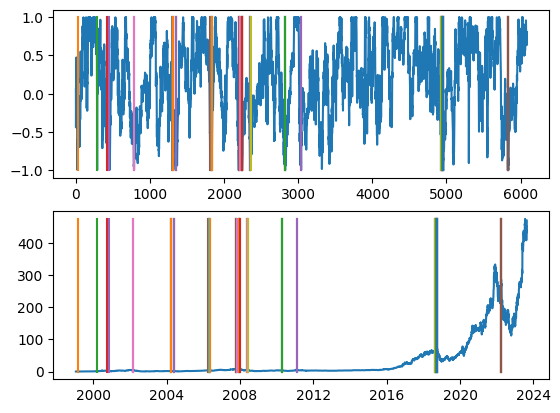

In [92]:
figure, axis = plt.subplots(2)
axis[0].plot(answer)
axis[1].plot(prices)
for pos in range(len(answer)):
    if answer[pos] < -0.99:
        axis[0].plot([pos, pos], [-1, 1])
        axis[1].plot([prices.keys()[pos], prices.keys()[pos]], [0, max(prices)])
plt.show()

Creates features for training

In [93]:
sma10 = get_sma(prices, 10)
sma30 = get_sma(prices, 20)
sma50 = get_sma(prices, 50)
sma100 = get_sma(prices, 100)
sd10 = get_sd(prices, 10)
sd30 = get_sd(prices, 20)
sd50 = get_sd(prices, 50)
sd100 = get_sd(prices, 100)

LONGEST_SMA = 100
if MAX_HOLDING < LONGEST_SMA:
    answer = answer.iloc[LONGEST_SMA - MAX_HOLDING:]

x = []
y = []
for pos in range(0, len(prices) - LONGEST_SMA):
    temp = [0] * 200
    x.append([sma10[pos], sma30[pos], sma50[pos], sma100[pos], sd10[pos], sd30[pos], sd50[pos], sd100[pos]])
    ans = (answer[pos] + 1) / 2
    y.append(ans)
x = np.array(x)
y = np.array(y)
prices = prices[MAX_HOLDING - LONGEST_SMA:len(prices) - MAX_HOLDING]
print(len(x), len(y))

6085 6085


Training and testing dataset includes everything until the last 10% history of the stock. This is done to simulate the neural net never having seen the last 10% of prices so we can test its validity.

In [11]:
TRAIN_AMNT = 0.9
x_train, x_test, y_train, y_test = train_test_split(x[:round(len(x)*TRAIN_AMNT)], y[:round(len(y)*TRAIN_AMNT)], test_size=0.2)

In [12]:
def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(8,), name='layers_flatten'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
  ])

In [13]:
model = create_model()
model.compile(optimizer='adam',
              loss='mean_absolute_error',)

c:\Users\kahns_\anaconda3\envs\WatStreet\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=50, 
          validation_data=(x_test, y_test), 
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4989 - val_loss: 0.1617
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1679 - val_loss: 0.1602
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1548 - val_loss: 0.1291
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1223 - val_loss: 0.1102
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1109 - val_loss: 0.1075
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1123 - val_loss: 0.1112
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1111 - val_loss: 0.1062
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1033 - val_loss: 0.1012
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1049 - val_loss: 0.1004
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - val_loss: 0.1013
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0999 - val_loss: 0.1000
Epoch 12/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

In [84]:
predictions = model.predict(x[round(len(x)*TRAIN_AMNT):])
dates = prices.keys()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Normalizes the prediction between [-1, 1]

In [94]:
average = round(float((sum(predictions) / len(predictions))[0]), 5)
for pos in range(len(predictions)):
    predictions[pos] -= average

to_normalize = max(abs(min(predictions)), abs(max(predictions)))
for pos in range(len(predictions)):
    predictions[pos] /= to_normalize

Plots the 5 best and 5 worst positions to by the stock and general buy and sell positions

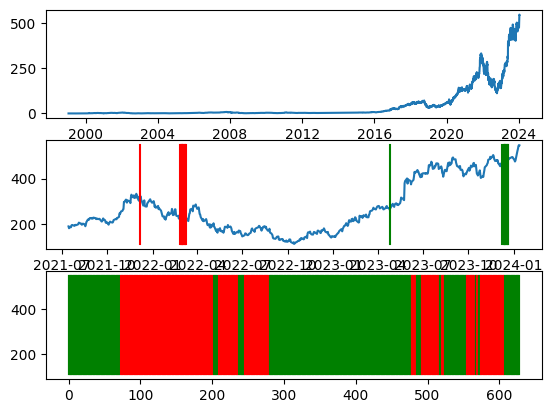

In [86]:
CONFIDENT_X = 10
figure, axis = plt.subplots(3)
axis[0].plot(prices)
axis[1].plot(prices[int(TRAIN_AMNT * len(prices)):])

bests = [(float(predictions[x][0]), dates[int(TRAIN_AMNT * len(prices))]) for x in range(CONFIDENT_X)]
worsts = [(float(predictions[x][0]), dates[int(TRAIN_AMNT * len(prices))]) for x in range(CONFIDENT_X)]

for pred_pos in range(len(predictions[CONFIDENT_X:])):
    val = predictions[CONFIDENT_X:][pred_pos]
    min_bests = 100
    max_worsts = -100        
    for pos in range(CONFIDENT_X):
        if bests[pos][0] < min_bests:
            min_pos = pos
            min_bests = bests[pos][0]
        if worsts[pos][0] > max_worsts:
            max_pos = pos
            max_worsts = worsts[pos][0]
    
    if float(val[0]) > min_bests:
        bests.pop(min_pos)
        bests.append((float(val[0]), dates[int(TRAIN_AMNT * len(prices)) + pred_pos]))
    if float(val[0]) < max_worsts:
        worsts.pop(max_pos)
        worsts.append((float(val[0]), dates[int(TRAIN_AMNT * len(prices)) + pred_pos]))
min_y = min(prices[int(TRAIN_AMNT * len(prices)):])
max_y = max(prices[int(TRAIN_AMNT * len(prices)):])
avg = sum(predictions) / len(predictions)
for pos in range(CONFIDENT_X):
    axis[1].plot([bests[pos][1], bests[pos][1]], [min_y, max_y], 'g')
    axis[1].plot([worsts[pos][1], worsts[pos][1]], [min_y, max_y], 'r')
for pos in range(len(predictions)):
    if predictions[pos][0] > avg:
        axis[2].plot([pos, pos], [min_y, max_y], 'g')
    else:
        axis[2].plot([pos, pos], [min_y, max_y], 'r')
plt.show()

In [ ]:
path = 'Models/' + TICKER + '/'
if not os.path.exists(path):
    os.makedirs(path)
else:
    shutil.rmtree(path)
    os.makedirs(path)
model.save(path)
model.save_weights(path)